In [1]:
from importlib import reload
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
from aFunctions import *
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
for i in ['aCrossSection', 'rCrossSection']:
    featimp = 'plots/FeatureImportance/'+i
    if not os.path.exists(featimp):
        print(i)
        os.makedirs(featimp)

# Read Data

- In prior EDA notebook we created features, and wrote our data to CSV files
- In this notebook we will model our data, and decide which features provide the most value
- For this Set we will focus on our DEFENSIVE bond like ETF's
- We will train a seperate model for risk on sectors broadly


In [181]:
mdatar = pd.read_csv('data/mdata-defensive.csv', 
                     index_col = 0).sort_values(by=['period', 'ticker'])
mdatar.index = pd.to_datetime(mdatar.index)
mdatar['period.1'] = pd.to_datetime(mdatar['period.1'])
tick = 'rCrossSection'
retwindow = 'relRtnF063'
mdatar = mdatar.dropna()
print(mdatar['ticker'].unique())
mdatar.shape

['TLT' 'XLP' 'XLU' 'XLV']


(14232, 73)

In [109]:
with open('data/fnamesR.txt', 'r') as f:
    rFeatures = [line.rstrip('\n') for line in f]

In [110]:
mdatar.columns

Index(['clHv010', 'clHv021', 'clHv063', 'clHv126', 'clHv252', 'clRtnH010',
       'clRtnH021', 'clRtnH063', 'clRtnH126', 'clRtnH252', 'relHv010',
       'relHv021', 'relHv063', 'relHv126', 'relHv252', 'relRtnH010',
       'relRtnH021', 'relRtnH063', 'relRtnH126', 'relRtnH252',
       'TrendMASlope10', 'TrendMASlope50', 'TrendMASlope100',
       'TrendMASlope200', 'MeanRevRSI14d', 'TrendRSIs14d', 'MeanRevRSI63d',
       'TrendRSIs63d', 'TrendhBma', 'TrendlBma', 'TrendabsBma', 'aroon_up',
       'aroon_down', 'aroon_diff', 'MACD_12_26', 'MACD_diff', 'MACD_sign',
       'MACD_36_78', 'MACD_sign3x', 'MeanRevFF', 'MeanRevFFEWMA1',
       'MeanRevFFEWMA2', 'MeanRevFFDiff', 'st6mRealized', 'Ret12m1m',
       'Ret12m6m', 'Ret6m1m', 'Ret6m2w', 'Ret3m2w', 'st6mRealized-Rel',
       'Ret12m1m-Rel', 'Ret12m6m-Rel', 'Ret6m1m-Rel', 'Ret6m2w-Rel',
       'Ret3m2w-Rel', 'hCorr', 'FIst6mRealized', 'FIRet12m1m', 'FIRet3m2w',
       'FIFF', 'FIRSI14d', 'FIRSIs14d', 'FIRSI63d', 'FIRSIs63d', 'ticker',
    

In [111]:
mdatar.columns[mdatar.columns.isin(rFeatures) == False]

Index(['hCorr', 'ticker', 'period.1', 'forwardmmS', 'forwardstdS',
       'relRtnF063', 'SiderelRtnF063', 'relRtn', 'clRtn'],
      dtype='object')

In [113]:
bTestRetWindow = 'relRtnF063'
Y_r = mdatar[[bTestRetWindow, 'ticker']]
Y_r[bTestRetWindow] = np.exp(mdatar[bTestRetWindow]) - 1
Y_r = Y_r.reset_index()
Sharpe_S = Y_r.pivot(index='period', columns='ticker').describe()[bTestRetWindow]
Sharpe_S['CrossSection'] = Y_r.describe()
Sharpe_S.loc['AnnRet'] = ((Sharpe_S.loc['mean']+1)**(252/int(bTestRetWindow[-3:]))-1)
Sharpe_S.loc['AnnVol'] = (Sharpe_S.loc['std']*np.sqrt(252/int(bTestRetWindow[-3:])))
Sharpe_S = (Sharpe_S*100)
Sharpe_S.loc['AnnSharpe'] = Sharpe_S.loc['AnnRet']/Sharpe_S.loc['AnnVol']
Sharpe_S.round(2)

ticker,TLT,XLP,XLU,XLV,CrossSection
count,355800.00,355800.00,355800.00,355800.00,1423200.00
mean,0.29,0.43,0.22,0.38,0.33
std,12.80,5.02,6.70,4.83,8.02
min,-37.34,-12.76,-17.75,-17.34,-37.34
25%,-7.01,-3.00,-4.46,-2.44,-4.05
50%,-1.77,-0.25,-0.32,0.38,-0.30
75%,4.87,3.22,4.43,3.14,3.65
max,93.46,31.58,25.40,21.37,93.46
AnnRet,1.17,1.75,0.90,1.53,1.33
AnnVol,25.61,10.05,13.39,9.66,16.04


# Relative Returns

- Based on our process for Absolute Returns we will mimic our modeling of Relative to SPY returns 
- We will train a large model as before and reduce features using our importance measures
- Once our side model is trained, we can use shap package as before to understand model forecasts

In [114]:
retwindow = 'relRtnF063'
train_end = '2017-9-30'
test_start = '2017-12-31'

X = mdatar[rFeatures]
Y = mdatar['Side'+retwindow]
t1 = pd.Series(Y.index, index=Y.index, name = 't1')

X_train = X.loc[mdatar.index < train_end]
X_test = X.loc[mdatar.index > test_start]
Y_train = Y.loc[mdatar.index < train_end]
Y_test = Y.loc[mdatar.index > test_start]
wa = (mdatar['forwardmmS'] - .5).abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)
print('RELATIVE RETURNS')
print('Dropped Records', mdatar.shape[0] - Y_train.shape[0] - Y_test.shape[0])
print('X Shape', X.shape)
print(X.index.min())

RELATIVE RETURNS
Dropped Records 252
X Shape (14232, 64)
2005-06-30 00:00:00


In [33]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=.85, rc={"lines.linewidth": 2.})
sim = 1

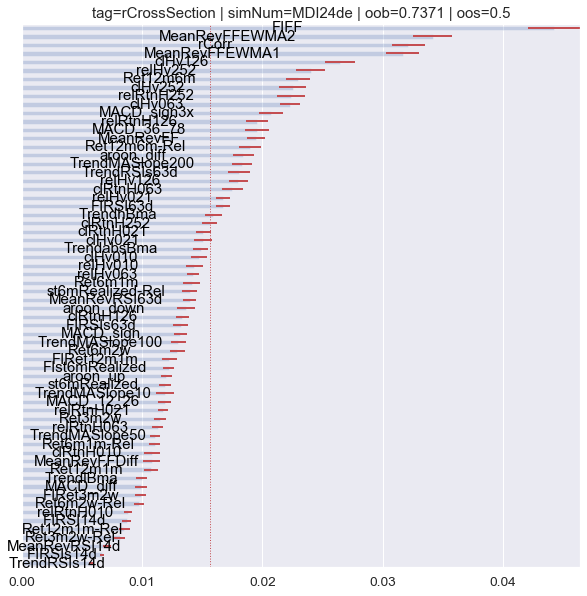

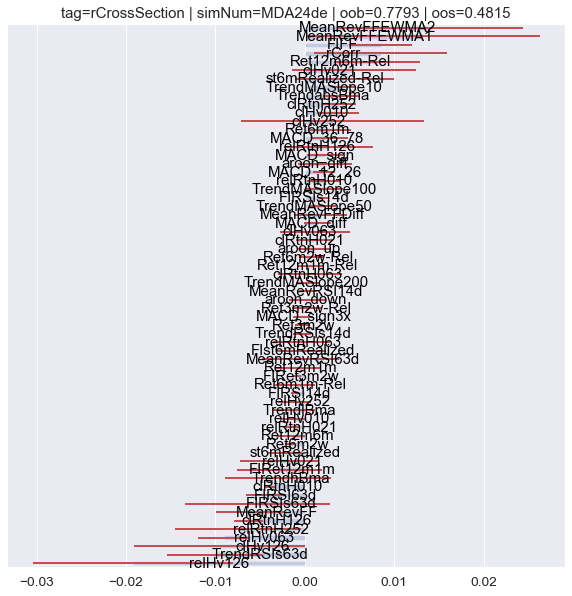

In [115]:
clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'gini', bootstrap=False, class_weight='balanced',
                             max_depth=5, max_features=2, min_samples_split=.02)
bc=BaggingClassifier(base_estimator=clf, n_estimators=200,max_samples=.5,max_features=1.0)
bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])


OOB, OOS = bc.score(X_train,Y_train), bc.score(X_test,Y_test)
MDI = featImpMDI(bc, X_train.columns)  
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDI, OOB, OOS, 'MDI', tag=tick, simNum='MDI'+str(sim)+'de')

MDA, OOS, OOB = featImpMDA(bc, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .01, scoring='accuracy')

plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA'+str(sim)+'de')

sim += 1

Calculating SFI ....
clHv010
clHv021
clHv063
clHv126
clHv252
clRtnH010
clRtnH021
clRtnH063
clRtnH126
clRtnH252
relHv010
relHv021
relHv063
relHv126
relHv252
relRtnH010
relRtnH021
relRtnH063
relRtnH126
relRtnH252
TrendMASlope10
TrendMASlope50
TrendMASlope100
TrendMASlope200
MeanRevRSI14d
TrendRSIs14d
MeanRevRSI63d
TrendRSIs63d
TrendhBma
TrendlBma
TrendabsBma
aroon_up
aroon_down
aroon_diff
MACD_12_26
MACD_diff
MACD_sign
MACD_36_78
MACD_sign3x
MeanRevFF
MeanRevFFEWMA1
MeanRevFFEWMA2
MeanRevFFDiff
st6mRealized
Ret12m1m
Ret12m6m
Ret6m1m
Ret6m2w
Ret3m2w
st6mRealized-Rel
Ret12m1m-Rel
Ret12m6m-Rel
Ret6m1m-Rel
Ret6m2w-Rel
Ret3m2w-Rel
FIst6mRealized
FIRet12m1m
FIRet3m2w
FIFF
FIRSI14d
FIRSIs14d
FIRSI63d
FIRSIs63d
rCorr


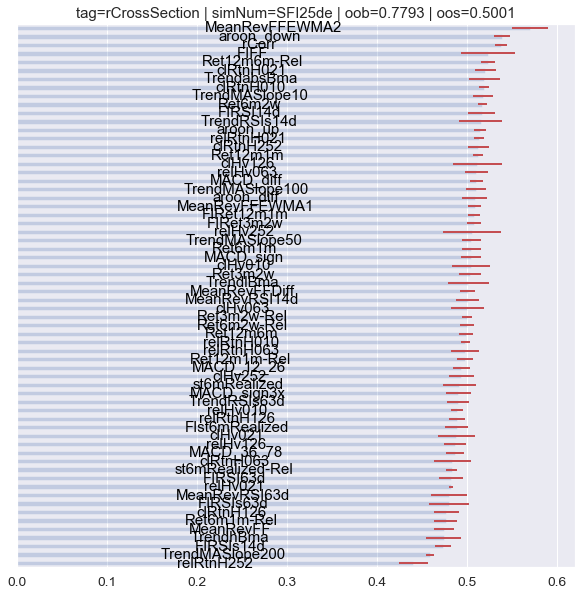

In [116]:
print('Calculating SFI ....')
clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'gini', bootstrap=False, class_weight='balanced',
                             max_depth=5, max_features=1, min_samples_split=.02)
bc=BaggingClassifier(base_estimator=clf, n_estimators=200,max_samples=.5,max_features=1.0)
bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
SFI = ImpSFI(featNames = X.columns.values, clf = bc, trnsX=X,  Y=Y, wts = wts,  
             scoring = 'accuracy', t1 = t1)
plotFeatImportances('plots/FeatureImportance/'+tick+'/',
                    SFI,  OOB,  SFI['mean'].mean(), 'SFI',  tag=tick,  simNum='SFI'+str(sim)+'de')

In [118]:
MDI_Feats = list(MDI[MDI['mean']> MDI['mean'].quantile(.80)].sort_values(by=['mean'], ascending=False).index)
SFI_Feats = list(SFI[SFI['mean']> SFI['mean'].quantile(.80)].index)
MDA_Feats = list(MDA[MDA['mean']> MDA['mean'].quantile(.80)].sort_values(by=['mean'], ascending=False).index)
selFeats = np.concatenate((MDI_Feats, MDA_Feats, SFI_Feats))
selFeats = sorted(list(set(selFeats)))
print(len(selFeats))
selFeats

28


['FIFF',
 'FIRSI14d',
 'MACD_36_78',
 'MACD_sign3x',
 'MeanRevFFEWMA1',
 'MeanRevFFEWMA2',
 'Ret12m6m',
 'Ret12m6m-Rel',
 'Ret6m1m',
 'Ret6m2w',
 'TrendMASlope10',
 'TrendRSIs14d',
 'TrendabsBma',
 'aroon_down',
 'aroon_up',
 'clHv010',
 'clHv021',
 'clHv063',
 'clHv126',
 'clHv252',
 'clRtnH010',
 'clRtnH021',
 'clRtnH252',
 'rCorr',
 'relHv252',
 'relRtnH126',
 'relRtnH252',
 'st6mRealized-Rel']

# Feature Selection

- Below we use a blend of top MDI, SFI, & MDA features
- This is paired down from a starting set of roughly ~ 90 Features, Using our MDI/MDA/SFI on all features, we start with the top 20% of features for each, see above
- We take the top 20% set of features as a starting point to re-run MDI / MDA importances
- We also tune our model by altering: class wts, tree depth, min sample split, # of trees, max samples per tree
- Each of these can be used to help reduce model overfitting & improve cross validated performance


In [212]:
bcparam = dict(classwtd = 'balanced', 
               mdepth = 5, 
               mfeats = 1,
               minssplit = .02,
               nest= 200, 
               maxsample=.7)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.})


selFeats = [
 'MACD_36_78',
 'MeanRevFFEWMA2',
 'Ret12m6m-Rel',
 'clHv063',
 'clRtnH021',
 'clRtnH252']

len(selFeats)

6

ABSOLUTE RETURNS
Dropped Records 256
TEST Data:  2144 | Train Data:  11832
Train Classification - Bagging
              precision    recall  f1-score   support

        -1.0       0.75      0.58      0.65      6140
         1.0       0.64      0.79      0.70      5692

    accuracy                           0.68     11832
   macro avg       0.69      0.68      0.68     11832
weighted avg       0.69      0.68      0.68     11832

Test Classification - Bagging
              precision    recall  f1-score   support

        -1.0       0.69      0.21      0.32      1168
         1.0       0.48      0.89      0.63       976

    accuracy                           0.52      2144
   macro avg       0.59      0.55      0.47      2144
weighted avg       0.60      0.52      0.46      2144

Confusion Matrix - Test Data
[[243 925]
 [107 869]]


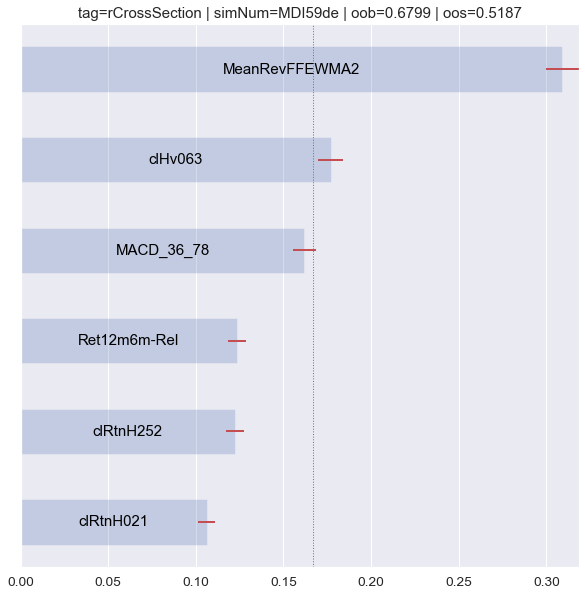

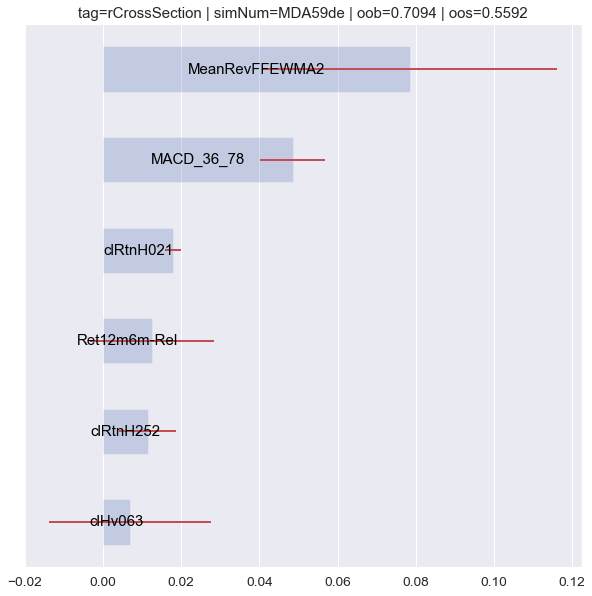

In [213]:
train_end = '2017-03-31' #'2017-03-31'
test_start = '2017-06-30' #'2017-06-30'

X = mdatar[selFeats]
Y = mdatar['Side'+retwindow]
t1 = pd.Series(Y.index, index=Y.index, name = 't1')

X_train = X.loc[Y.index < train_end]
X_test = X.loc[Y.index > test_start]
Y_train = Y.loc[Y.index < train_end]
Y_test = Y.loc[Y.index > test_start]

wa = mdatar['forwardstdS'].abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)

print('ABSOLUTE RETURNS')
print('Dropped Records', mdatar.shape[0] - Y_train.shape[0] - Y_test.shape[0])
print('TEST Data: ',Y_test.shape[0], '| Train Data: ',Y_train.shape[0])

clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam['classwtd'],
                             max_depth=bcparam['mdepth'],
                             max_features=bcparam['mfeats'],
                             min_samples_split=bcparam['minssplit'])

bc=BaggingClassifier(base_estimator=clf, 
                     n_estimators=bcparam['nest'],
                     max_samples=bcparam['maxsample'],
                     max_features=1.0)

bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
pred = bc.predict(X_test)
proba = bc.predict_proba(X_test)
confusion_m = confusion_matrix(Y_test, pred)

print('Train Classification - Bagging')
print(classification_report(Y_train, bc.predict(X_train)))
print('Test Classification - Bagging')
print(classification_report(Y_test, pred))
print('Confusion Matrix - Test Data')
print(confusion_m)

OOB, OOS = bc.score(X_train,Y_train), bc.score(X_test,Y_test)
MDI = featImpMDI(bc, X_train.columns)  
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                     MDI, OOB, OOS, 'MDI', tag=tick, simNum='MDI'+str(sim)+'de')

MDA, OOS, OOB = featImpMDA(bc, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='accuracy')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA'+str(sim)+'de')

sim += 1

Train Classification - Logistic Regression
              precision    recall  f1-score   support

        -1.0       0.63      0.59      0.61      6140
         1.0       0.58      0.63      0.60      5692

    accuracy                           0.61     11832
   macro avg       0.61      0.61      0.61     11832
weighted avg       0.61      0.61      0.61     11832

Test Classification - Logistic Regression
              precision    recall  f1-score   support

        -1.0       0.83      0.29      0.43      1168
         1.0       0.52      0.93      0.67       976

    accuracy                           0.58      2144
   macro avg       0.68      0.61      0.55      2144
weighted avg       0.69      0.58      0.54      2144

Confusion Matrix - Test Data
[[343 825]
 [ 69 907]]



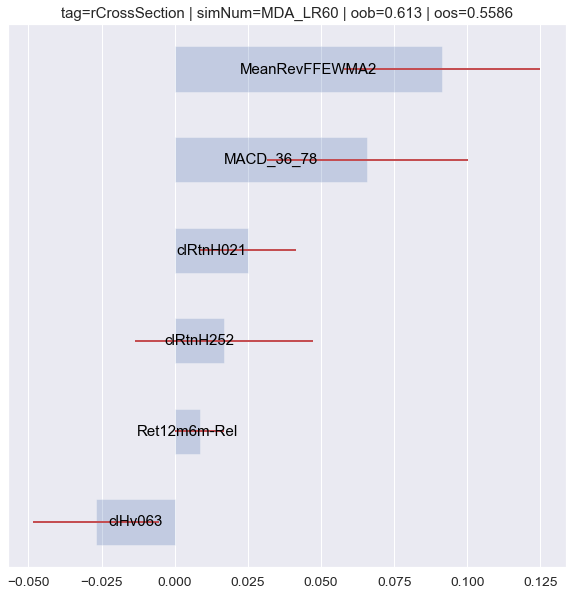

In [214]:
lr = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
lr.fit(X_train,Y_train,sample_weight = wts.loc[wts.index < train_end])
predlr = lr.predict(X_test)
confusion_m = confusion_matrix(Y_test, predlr)
print('Train Classification - Logistic Regression')
print(classification_report(Y_train, lr.predict(X_train)))
print('Test Classification - Logistic Regression')
print(classification_report(Y_test, predlr))
print('Confusion Matrix - Test Data')
print(confusion_m) 
print('')

MDA, OOS, OOB = featImpMDA(lr, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='accuracy')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA_LR'+str(sim))
sim += 1

bal-0.7mrs-5md-0.02mss-200t


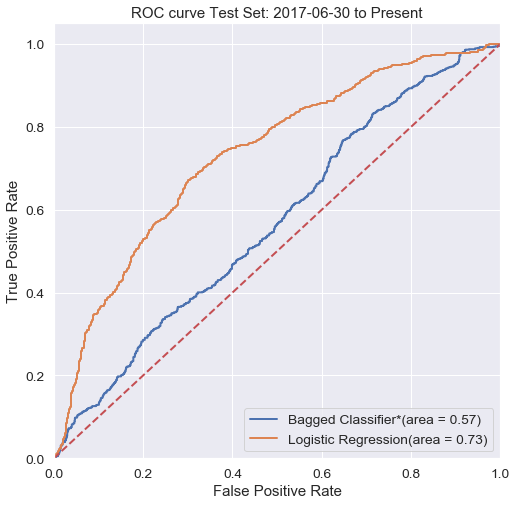

,lr,bal-0.7mrs-5md-0.02mss-200t
count,865.000000,1009.000000
mean,0.574900,0.559544
std,0.084450,0.059862
min,0.290009,0.366166
25%,0.530005,0.530072
50%,0.586085,0.570330
75%,0.620227,0.589164
max,1.769214,1.711259


In [215]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
path = 'plots/FeatureImportance/'+tick+'/'
bcname = bcparam['classwtd'][0:3]+'-'+str(bcparam['maxsample'])+'mrs-'+str(bcparam['mdepth'])+'md-'+str(bcparam['minssplit'])+'mss-'+str(bcparam['nest'])+'t'
print(bcname)
tree_roc_auc1 = roc_auc_score(Y_test, pred)
logit_roc_auc1 = roc_auc_score(Y_test, lr.predict(X_test))
tree_roc_auc = roc_auc_score(Y_test, proba[:,1])
logit_roc_auc = roc_auc_score(Y_test, lr.predict_proba(X_test)[:,1])

fpr_l, tpr_l, thresholds_l = roc_curve(Y_test, lr.predict_proba(X_test)[:,1])
fpr_l1, tpr_l1, _ = roc_curve(Y_test, lr.predict(X_test))
thres_df = pd.Series(list(thresholds_l), name = 'lr').describe().to_frame()

fpr, tpr, thresholds = roc_curve(Y_test, proba[:,1])
fpr1, tpr1, _ = roc_curve(Y_test, pred)
thres_df[bcname] = pd.Series(list(thresholds)).describe()

fpr_t, tpr_t, _ = roc_curve(Y_test, np.full(Y_test.shape,.60))

plt.figure()
plt.plot(fpr, tpr, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc)
plt.plot(fpr_l, tpr_l, label='Logistic Regression(area = %0.2f)' % logit_roc_auc)
#plt.plot(fpr1, tpr1, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc1)
#plt.plot(fpr_l1, tpr_l1, label='Logistic Regression(area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test Set: '+test_start+' to Present')
plt.legend(loc="lower right")
plt.savefig(path+'ROC_'+bcname+'.png')
plt.show()
thres_df

In [216]:
import xgboost
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import shap
shap.initjs()

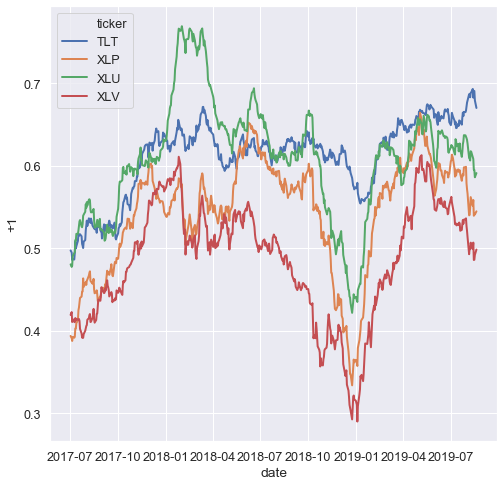

In [217]:
plot_df = pd.DataFrame(lr.predict_proba(X_test), index=Y_test.index, columns=['-1', '+1'])
plot_df['ticker'] = mdatar.loc[mdatar.index > test_start]['ticker']
plot_df['date'] = Y_test.index

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.})
sns.lineplot(x="date", y="+1", hue='ticker', data=plot_df)

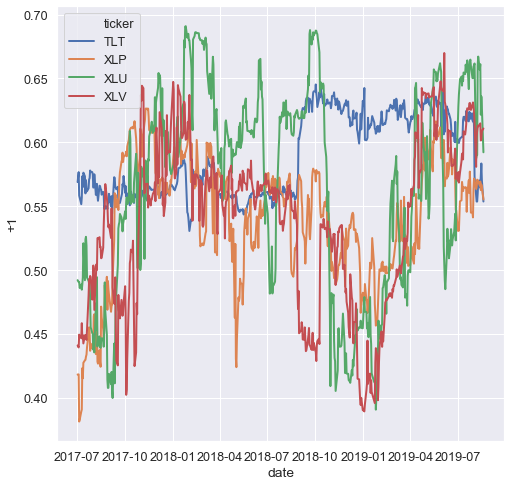

In [218]:
plot_df = pd.DataFrame(bc.predict_proba(X_test), index=Y_test.index, columns=['-1', '+1'])
plot_df['ticker'] = mdatar['ticker'].loc[mdatar.index > test_start]
plot_df['date'] = Y_test.index
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.})
sns.lineplot(x="date", y="+1", hue='ticker', data=plot_df)

# SHAP plots & Feature Interaction / Effect
- Below we fit an XGboost approximation to our above bagged tree model
- This can be used in conjunction with the shap package* to plot shapely additive value plots
- First we plot force plots for 12-2018 & 3-2019, showing feature contribution to forecast for those dates
- Next we show a shap summary plot to show how the range of our values causes our forecast to change
- finally we plot all our interaction plots, to show interaction for each feature across the whole training data set

see https://github.com/slundberg/shap for more details

In [219]:
params = {
  'silent':1,
  'verbosity':1,
  'colsample_bytree': 1.0,
  'colsample_bylevel': 1/X_train.columns.shape[0],
  'learning_rate': 2,
  'max_depth': 5,
  'num_parallel_tree': 500,
  'objective': 'binary:logistic',
  'subsample': 0.7,
  'tree_method': 'auto',
  'min_child_weight': 20
}
xg = xgboost.train(params, xgboost.DMatrix(X_train, label=np.where(Y_train == -1, 0, 1)), 1)

y_pred = xg.predict(xgboost.DMatrix(X_test))
y_pred = np.where(y_pred<.50,-1,1)
confusion_m = confusion_matrix(Y_test, y_pred)

print('Confusion matrix XGBOOST RF - Test Set' )
print(confusion_m)
print(classification_report(Y_test, y_pred))
print('')

Confusion matrix XGBOOST RF - Test Set
[[374 794]
 [177 799]]
              precision    recall  f1-score   support

        -1.0       0.68      0.32      0.44      1168
         1.0       0.50      0.82      0.62       976

    accuracy                           0.55      2144
   macro avg       0.59      0.57      0.53      2144
weighted avg       0.60      0.55      0.52      2144




In [220]:
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X)

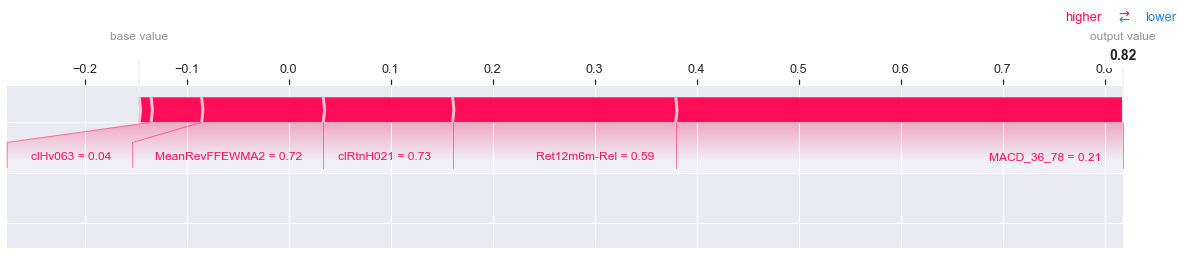

XLV


,2017-12-28 00:00:00,SHAP_Val
MACD_36_78,0.21,0.438628
MeanRevFFEWMA2,0.72,0.119293
Ret12m6m-Rel,0.59,0.218729
clHv063,0.04,0.049504
clRtnH021,0.73,0.126716
clRtnH252,0.76,0.011599


In [221]:
_date = '12-28-2017'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

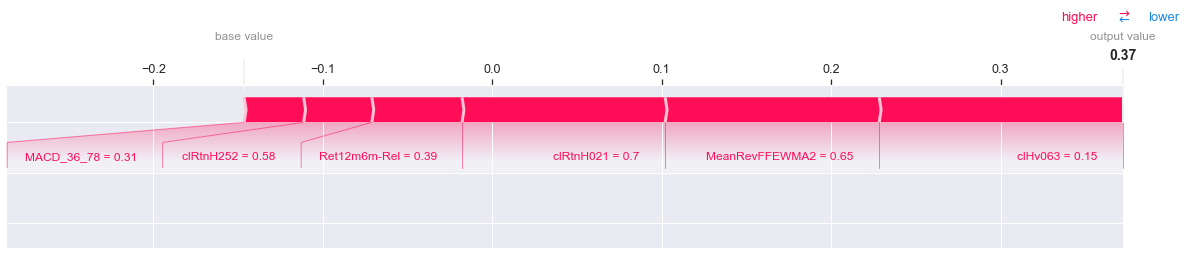

XLV


,2018-06-28 00:00:00,SHAP_Val
MACD_36_78,0.31,0.035095
MeanRevFFEWMA2,0.65,0.126314
Ret12m6m-Rel,0.39,0.053222
clHv063,0.15,0.143950
clRtnH021,0.70,0.119857
clRtnH252,0.58,0.040224


In [222]:
_date = '06-28-2018'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

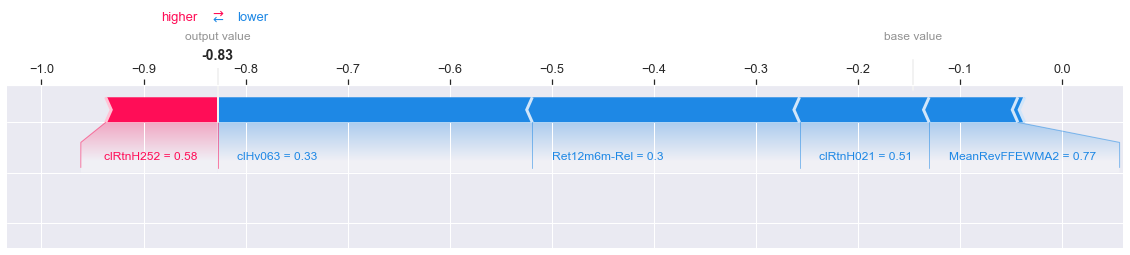

XLV


,2018-12-31 00:00:00,SHAP_Val
MACD_36_78,0.61,-0.006714
MeanRevFFEWMA2,0.77,-0.086937
Ret12m6m-Rel,0.30,-0.261786
clHv063,0.33,-0.308356
clRtnH021,0.51,-0.126961
clRtnH252,0.58,0.109573


In [223]:
_date = '12-31-2018'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

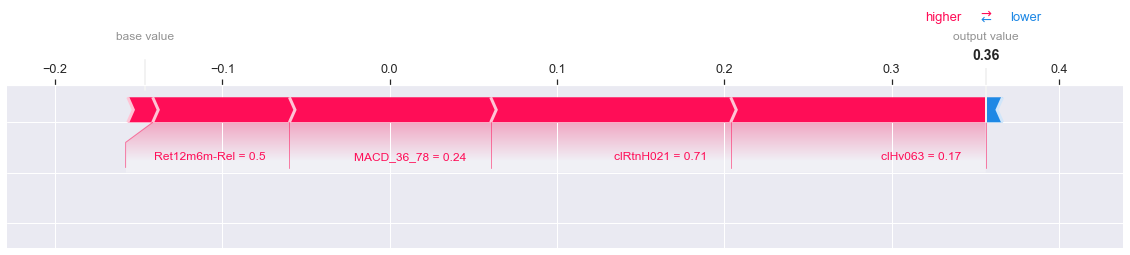

XLV


,2019-03-29 00:00:00,SHAP_Val
MACD_36_78,0.24,0.120260
MeanRevFFEWMA2,0.78,0.014881
Ret12m6m-Rel,0.50,0.081679
clHv063,0.17,0.152388
clRtnH021,0.71,0.143401
clRtnH252,0.69,-0.010086


In [224]:
_date = '3-29-2019'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

# Shap Plot Notes
looking at the summary plot, here is a short summary of what the model thinks:
- Higher Momo Indicators, at extremes are actually contrarian indicators.
- IE Slope, RelReturn, Features High = Lower expected Return, & Vice Versa.
- Aroon diff is simply the Aroon Up - Aroon Down indicator simply tracks 50days - Periods since 50 per high. IE high Aroon_diff = strong uptrend in the last ~ 50 days.
- Fractional Diff Features vs it's 20D exponential MA is more of a value measure, where lower values = positive returns, and vice versa
- high TLT 10d realized vs 6m Realized equated to high returns on balance
- 3m Close-Close Realized seemed to center on really low/ high values to indicate negative returns, values in between seem to be negative indicators
- 63d RSI seems to function similar to Fractional differentation

# Dependence Plots
- Nothing especially interesting, except for realized versus momo. IE high realized in the Ticker/SPX performance and Trend Strong = Buy, & at some point this relationship flips
- This also appears to have some outlier values

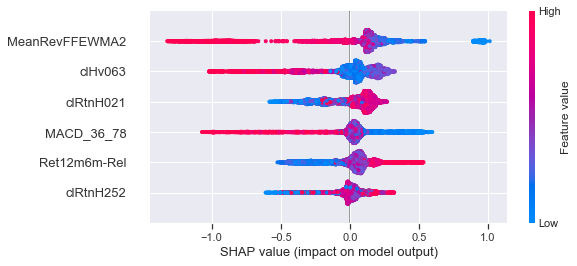

In [225]:
shap.summary_plot(shap_values, X)

Index(['MACD_36_78', 'MeanRevFFEWMA2', 'Ret12m6m-Rel', 'clHv063', 'clRtnH021',
       'clRtnH252'],
      dtype='object')


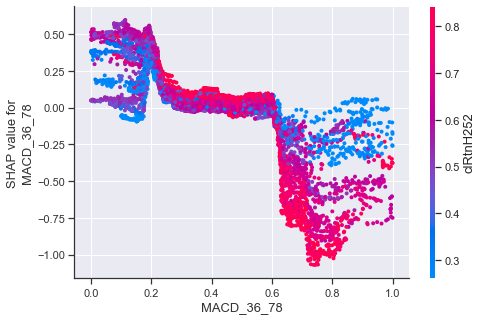

In [227]:
print(X.columns)
shap.dependence_plot('MACD_36_78', shap_values, X)

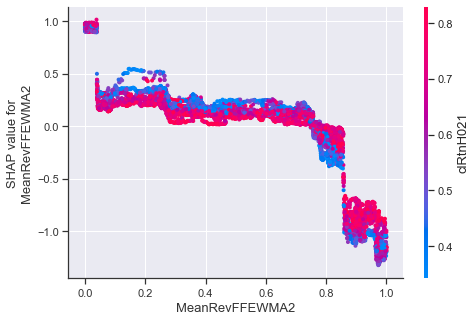

In [228]:
shap.dependence_plot('MeanRevFFEWMA2', shap_values, X)

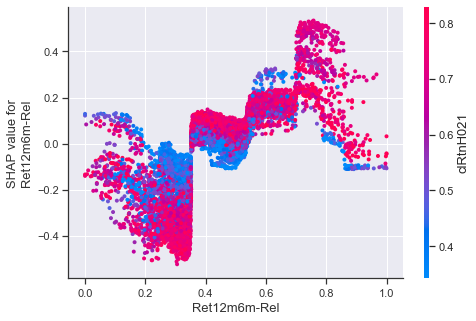

In [229]:
shap.dependence_plot('Ret12m6m-Rel', shap_values, X)

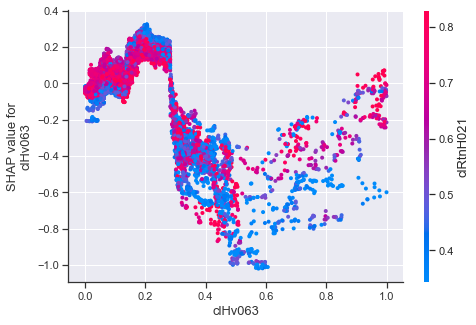

In [230]:
shap.dependence_plot('clHv063', shap_values, X)

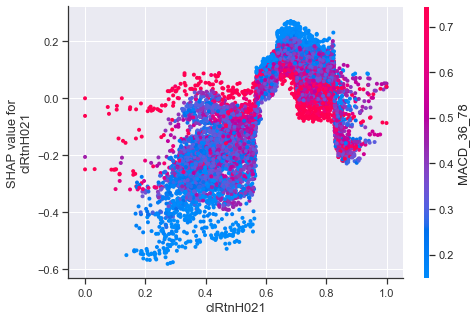

In [231]:
shap.dependence_plot('clRtnH021', shap_values, X)

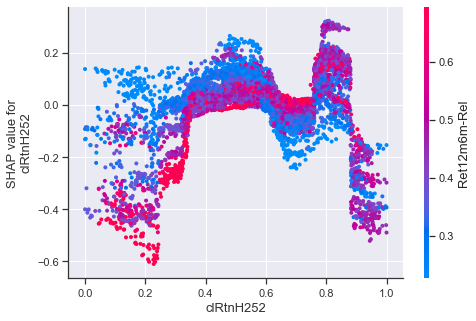

In [232]:
shap.dependence_plot('clRtnH252', shap_values, X)

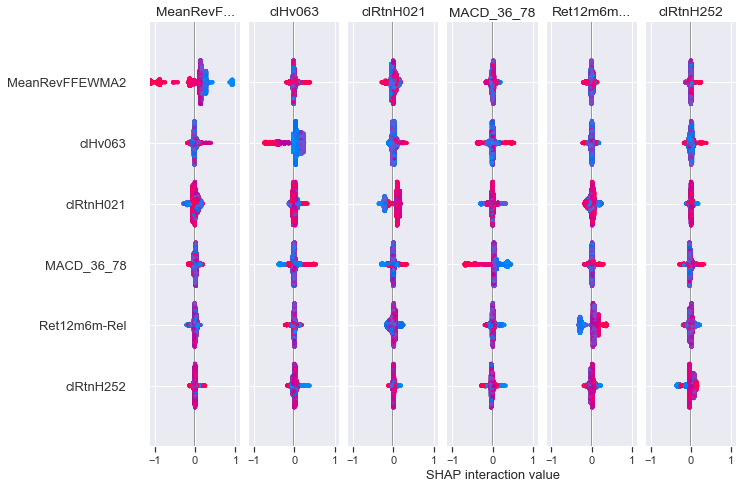

In [233]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

In [234]:
print(X.columns)

Index(['MACD_36_78', 'MeanRevFFEWMA2', 'Ret12m6m-Rel', 'clHv063', 'clRtnH021',
       'clRtnH252'],
      dtype='object')


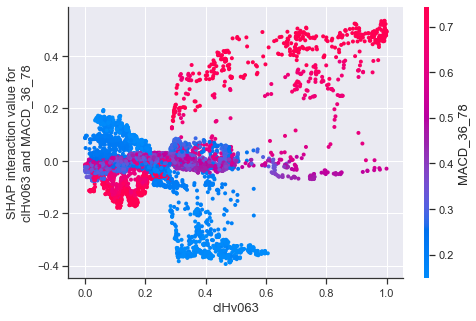

In [236]:
shap.dependence_plot(
    ('clHv063', "MACD_36_78"),
    shap_interaction_values, X,
)

# BACKTESTING! 
- finally we will backtest our model using the Combinatorial Cross Validated & Purged backtest (Lopez De Prado 2018)
- Given our lack of success in using sizing models on our last go around, we will only use side models in conjunction with LR
- Each variation will use a Logistic Regression & Bagged Random Forest Model
- Side only will just use Base (LR or RF), +1/-1 forecast only
- tcost will be set on round trip switches, starting at 10BP to go from +1 to -1
- Each ticker will have an even wt allocation to risk with absolute value leverage at 100%
- As a refresher we can post our sharpe expectations below based on passive buy/hold long ticker/spy


In [238]:
bcparam = dict(classwtd = 'balanced', 
               mdepth = 5, 
               mfeats = 1,
               minssplit = .02,
               nest= 200, 
               maxsample=.7)

clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam['classwtd'],
                             max_depth=bcparam['mdepth'],
                             max_features=bcparam['mfeats'],
                             min_samples_split=bcparam['minssplit'])

bc=BaggingClassifier(base_estimator=clf, 
                     n_estimators=bcparam['nest'],
                     max_samples=bcparam['maxsample'],
                     max_features=1.0)

print('Sign Model')
print(bc)
print('  ')

Sign Model
BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=5,
                                                        max_features=1,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=0.02,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=1,
                                                        n_jobs

In [239]:
lr = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
lrs = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
print('Sign Model')
print(lr)

Sign Model
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [254]:
selFeatsSign = selFeats

retwindow = 'relRtnF063'
bTestRetWindow = 'relRtnF063' # rtnFv001 rtnFv063

X = mdatar[selFeatsSign]
X_s = X
Y = mdatar['Side'+retwindow]

Y_r = mdatar[[bTestRetWindow, 'ticker']]
Y_r[bTestRetWindow] = np.exp(mdatar[bTestRetWindow]) - 1
Y_r = Y_r.reset_index()

wa = mdatar['forwardstdS'].abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)

print('X Size/Sign shape', X_s.shape,X.shape)
print(Y_r.period.min())

X Size/Sign shape (14232, 6) (14232, 6)
2005-06-30 00:00:00


In [256]:
simnum = 1
Sharpe_S.round(2)

ticker,TLT,XLP,XLU,XLV,CrossSection
count,355800.00,355800.00,355800.00,355800.00,1423200.00
mean,0.29,0.43,0.22,0.38,0.33
std,12.80,5.02,6.70,4.83,8.02
min,-37.34,-12.76,-17.75,-17.34,-37.34
25%,-7.01,-3.00,-4.46,-2.44,-4.05
50%,-1.77,-0.25,-0.32,0.38,-0.30
75%,4.87,3.22,4.43,3.14,3.65
max,93.46,31.58,25.40,21.37,93.46
AnnRet,1.17,1.75,0.90,1.53,1.33
AnnVol,25.61,10.05,13.39,9.66,16.04


In [257]:
kn = [2, 35]
betSize = 1.0  #.016
tcS = 'I'

trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   lr, None, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side-LR'
trial_stats = trials


trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   bc, None, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side-BC'
trial_stats = trial_stats.append(trials)
trial_stats['btest_window '] = bTestRetWindow
simnum += 1


595 Paths
Test Set Obs in Years 0.81
TOTAL DATA in Years 14.12
0  Time elapsed 1
100  Time elapsed 2
200  Time elapsed 3
300  Time elapsed 4
400  Time elapsed 5
500  Time elapsed 6


"\ntrials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,\n                                   bc, None, X_s,\n                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,\n                                   leverage = betSize, tcostScore = tcS)\ntrials['ModelType'] = 'Side-BC'\ntrial_stats = trial_stats.append(trials)\ntrial_stats['btest_window '] = bTestRetWindow\nsimnum += 1\n"

In [264]:
trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   bc, None, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side-BC'
trial_stats = trial_stats.append(trials)
trial_stats['btest_window '] = bTestRetWindow
simnum += 1

595 Paths
Test Set Obs in Years 0.81
TOTAL DATA in Years 14.12
0  Time elapsed 1
100  Time elapsed 11
200  Time elapsed 19
300  Time elapsed 28
400  Time elapsed 38
500  Time elapsed 48


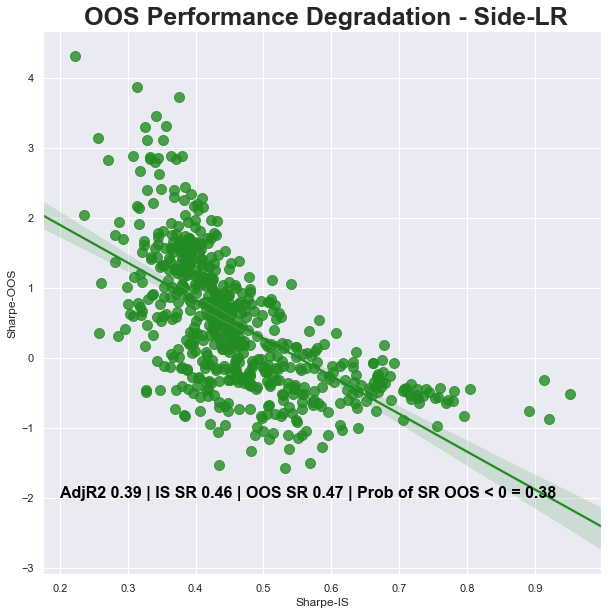

In [338]:
ModelType = 'Side-LR'
sns.set(rc={'figure.figsize':(10,10)})
ts = trial_stats[~trial_stats.isnull().any(axis=1)]
full_SR_OOS = ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].mean()
full_SR_IS = ts[ts['ModelType'] == ModelType]['Sharpe-IS'].mean()
full_prob0 = np.sum(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'] < 0)/ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].shape[0]
ols_m = sm.OLS(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'], 
               sm.add_constant(ts[ts['ModelType'] == ModelType]['Sharpe-IS']))
ols_r = ols_m.fit()
ss_p = np.round(ols_r.params, 2)
ss_adjr2 = np.round(ols_r.rsquared_adj,2)

ax = sns.regplot(x='Sharpe-IS', 
                 y='Sharpe-OOS', 
                 data = ts[ts['ModelType'] == ModelType], 
                 scatter_kws={"s": 100},
                 color = 'forestgreen')

ax.text(.2,-2, 
        "AdjR2 "+str(ss_adjr2)+" | IS SR "+str(np.round(full_SR_IS, 2))+" | OOS SR "+str(np.round(full_SR_OOS, 2))+" | Prob of SR OOS < 0 = "+str(np.round(full_prob0, 2)), 
        horizontalalignment='left', 
        size=16,
        weight='semibold',
        color='black')

ax.set_title(" OOS Performance Degradation - "+ModelType, weight='bold', size = 25)
plt.savefig('plots/FinalLogisticRegressionPlot.png')

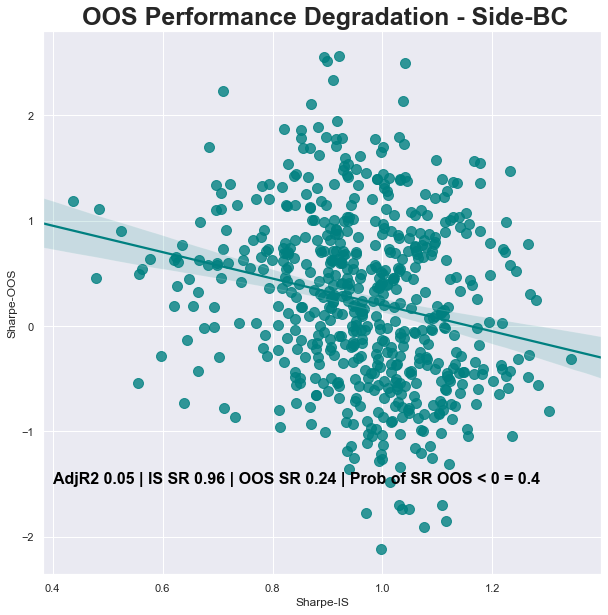

In [340]:
ModelType = 'Side-BC'
sns.set(rc={'figure.figsize':(10,10)})
ts = trial_stats[~trial_stats.isnull().any(axis=1)]
full_SR_OOS = ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].mean()
full_SR_IS = ts[ts['ModelType'] == ModelType]['Sharpe-IS'].mean()
full_prob0 = np.sum(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'] < 0)/ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].shape[0]
ols_m = sm.OLS(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'], 
               sm.add_constant(ts[ts['ModelType'] == ModelType]['Sharpe-IS']))
ols_r = ols_m.fit()
ss_p = np.round(ols_r.params, 2)
ss_adjr2 = np.round(ols_r.rsquared_adj,2)

ax = sns.regplot(x='Sharpe-IS', 
                 y='Sharpe-OOS', 
                 data = ts[ts['ModelType'] == ModelType], 
                 scatter_kws={"s": 100},
                 color = 'teal')

ax.text(.4,-1.5, 
        "AdjR2 "+str(ss_adjr2)+" | IS SR "+str(np.round(full_SR_IS, 2))+" | OOS SR "+str(np.round(full_SR_OOS, 2))+" | Prob of SR OOS < 0 = "+str(np.round(full_prob0, 2)), 
        horizontalalignment='left', 
        size=16,
        weight='semibold',
        color='black')

ax.set_title(" OOS Performance Degradation - "+ModelType, weight='bold', size = 25)
plt.savefig('plots/FinalRandomForestPlot.png')

In [274]:
print(trial_stats.columns)
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Sharpe-OOS']

Index(['Ann-Return-Net-OOS', 'Ann-Vol-OOS', 'Sharpe-OOS', 'Ann-Return-Net-IS',
       'Ann-Vol-IS', 'Sharpe-IS', 'TCost', 'TC-Score', 'Trialn', 'Sim_n',
       'TestYears', 'bTestRetWindow', 'ModelType', 'btest_window '],
      dtype='object')


ModelType,Side-BC,Side-LR
count,595.000000,595.000000
mean,0.244073,0.473143
std,0.817503,0.975299
min,-2.114040,-1.574095
25%,-0.372379,-0.317177
50%,0.261119,0.370131
75%,0.787799,1.104989
max,2.561135,4.308790


In [275]:
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Ann-Vol-OOS']

ModelType,Side-BC,Side-LR
count,595.000000,595.000000
mean,0.078764,0.081207
std,0.044451,0.052063
min,0.026407,0.021443
25%,0.048498,0.048003
50%,0.061424,0.062079
75%,0.092617,0.090351
max,0.242900,0.271892


In [276]:
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Ann-Return-Net-OOS']

ModelType,Side-BC,Side-LR
count,595.000000,595.000000
mean,0.016936,0.020278
std,0.068154,0.072071
min,-0.176342,-0.224005
25%,-0.023628,-0.021166
50%,0.015538,0.019736
75%,0.055492,0.067876
max,0.258774,0.219111


# Standard Walk Forward
   - Here we create a standard walk forward, with a warm up period ~ 10 years
   - Fit using data from 2007 - 2014, then fit monthly look forward predictions
   - We can use these predictions to create a simple long only performance
   - IE when we are short a name, just add SPY. 
   - This can also be done with a Long / Short Performance Set, using Leverage

In [369]:
def wForwardBacktest(X, Y, Y_r, clf, dStart, dtype = 'Monthly', 
                     windows = ['rtnFv001', 'SPYrtnFv001'], tcosts = 10):
    if dtype not in ['Monthly']:
        raise Exception('Walk forward timing method')
    if dtype == 'Monthly':
        wf_dates = Y_r.groupby([Y_r['period.1'].dt.year, 
                                Y_r['period.1'].dt.month]).max()['period.1'] 
        wf_dates = wf_dates[wf_dates > dStart].values
        annVal = 12
    pred=[]
    for i in np.arange(0,wf_dates.shape[0]-1):
        l1 = X[(X.index > wf_dates[i]) & (X.index <= wf_dates[i+1])].index
        l2 = X[X.index < wf_dates[i]].index
        
        X_test = X[X.index.isin(l1)]
        Y_test = Y[Y.index.isin(l1)]

        X_train = X[X.index.isin(l2)]
        Y_train = Y[Y.index.isin(l2)]
        
        wa = Y_r[Y_r.index.isin(l2)]['forwardstdS'].abs()
        wts = wa*1/(wa.sum())
        wts = getTimeDecay(wts,clfLastW=.25)
        
        clf.fit(X_train, Y_train, sample_weight=wts)
        pred_ = clf.predict(X_test)
        pred += list(pred_)
    
    Y_r = Y_r[Y_r.index > wf_dates[0]]
    Y_r['Predictions'] = pred
    
    Y_r[windows[0]] = np.exp(Y_r[windows[0]]*int(windows[0][-3:]))
    Y_r[windows[1]] = np.exp(Y_r[windows[1]]*int(windows[1][-3:]))
    #Y_r = Y_r.dropna()
    Y_r = Y_r.pivot(index='period.1', columns='ticker')
    
    _p = Y_r['Predictions'].ewm(span=21).mean()
    _p = pd.DataFrame(np.where(_p > 0, 1 , -1),_p.index,_p.columns)
    _p = _p[_p.index.isin(wf_dates)]
    _p.columns = pd.MultiIndex.from_product([[_p.columns.name], list(_p.columns.values)])
    
    for t in Y_r.columns.levels[1].values:
        ret = []
        for i in np.arange(1,wf_dates.shape[0]-1):
            _ret = Y_r[windows[0]][t]
            _ret = np.prod(_ret[(_ret.index > wf_dates[i]) & (_ret.index <= wf_dates[i+1])])
            ret.append(_ret)
        _p = _p.join(pd.DataFrame(ret, columns=pd.MultiIndex.from_product([[windows[0]], [t]]),
                     index=wf_dates[1:-1]))
        ret = []
        for i in np.arange(1,wf_dates.shape[0]-1):
            _ret = Y_r[windows[1]][t]
            _ret = np.prod(_ret[(_ret.index > wf_dates[i]) & (_ret.index <= wf_dates[i+1])])
            ret.append(_ret)

        _p = _p.join(pd.DataFrame(ret, columns=pd.MultiIndex.from_product([[windows[1]], [t]]),
                         index=wf_dates[1:-1]))
        
    pAlloc = 1/len(Y_r.columns.levels[1].values)
    tc_m = (_p['ticker'] != _p['ticker'].shift(1)) * tcosts/10000
    tc_m[tc_m.index == wf_dates[1]] = 0
    sRets = np.sum((np.where(_p['ticker'] == -1, 
                             _p[windows[1]],
                             _p[windows[0]])- tc_m)*pAlloc, axis=1).replace(0.0, 1.0)
    eRets = np.sum(_p[windows[0]]*pAlloc, axis=1) 
    bRets = _p[windows[1]].iloc[:,0]
    b_test = pd.DataFrame([], columns= ['Ann-Return', 
                                             'Ann-Vol',  
                                             'Sharpe',
                                             'Ann-Alpha-Bench',
                                             'Ann-Alpha-Eq',
                                             'TE-Bench', 
                                             'TE-EQwtd',
                                             'IR-SPY',
                                             'IR-EQ',
                                             'TestYears',
                                             'TCost'])

    annRetS = ((sRets.prod()**(annVal/len(sRets))-1)*100).round(2)
    annVolS = ((sRets.std()*np.sqrt(annVal))*100).round(2)
    annRetE = ((eRets.prod()**(annVal/len(eRets))-1)*100).round(2)
    annRetB = ((bRets.prod()**(12/len(bRets))-1)*100).round(2)
    IRb = np.round((annRetS-annRetB)/((sRets - bRets).std()*np.sqrt(annVal)*100), 3)
    IRe = np.round((annRetS-annRetE)/((sRets - eRets).std()*np.sqrt(annVal)*100), 3)
    b_test.loc['strat'] = [annRetS, 
                                 annVolS,  
                                 np.round(annRetS/annVolS,3),
                                 np.round(annRetS-annRetB,3),
                                 np.round(annRetS-annRetE,3),
                                 np.round((sRets - bRets).std()*np.sqrt(annVal)*100, 3), 
                                 np.round((sRets - eRets).std()*np.sqrt(annVal)*100, 3),
                                 IRb,
                                 IRe,
                                 np.round(len(sRets)/annVal,2),
                                 tcosts]
        
    return _p, b_test.T

In [370]:
mdata = pd.read_csv('data/raw_returns.csv', index_col = 0).sort_values(by=['period', 'ticker'])
mdata.index = pd.to_datetime(mdata.index)
mdata['period.1'] = pd.to_datetime(mdata['period'])
mdata = mdata[mdata.ticker == 'SPY'][['period.1', 'clRtn']]
mdata = mdata.rename(columns={"clRtn": "SPYrtnFv001"})

X = mdatar[selFeatsSign]
Y = mdatar['Side'+retwindow]
bTestRetWindow = 'clRtn'
Y_r = mdatar[[bTestRetWindow, 'ticker', 'forwardstdS', 'period.1']].rename(columns={"clRtn": "clRtn001"})
Y_r = Y_r.merge(mdata, on=['period.1'], how='left')
Y_r = Y_r.set_index([Y_r['period.1'].rename('period')])
wf_pred, wf_sRet = wForwardBacktest(X, Y, Y_r, lr, '2014-12-28', dtype = 'Monthly', 
                                       windows = ['clRtn001', 'SPYrtnFv001'])

wf_pred['ticker'].head()

,TLT,XLP,XLU,XLV
period.1,,,,
2015-01-30,1,-1,1,-1
2015-02-27,1,-1,1,-1
2015-03-31,1,-1,1,-1
2015-04-30,1,-1,1,-1
2015-05-29,1,-1,1,-1


In [371]:
wf_sRet

,strat
Ann-Return,10.090
Ann-Vol,8.000
Sharpe,1.261
Ann-Alpha-Bench,-0.540
Ann-Alpha-Eq,110.090
TE-Bench,8.807
TE-EQwtd,46.339
IR-SPY,-0.061
IR-EQ,2.376
TestYears,4.670


In [372]:
wf_pred['ticker']

,TLT,XLP,XLU,XLV
period.1,,,,
2015-01-30,1,-1,1,-1
2015-02-27,1,-1,1,-1
2015-03-31,1,-1,1,-1
2015-04-30,1,-1,1,-1
2015-05-29,1,-1,1,-1
2015-06-30,1,-1,1,-1
2015-07-31,1,-1,1,-1
2015-08-31,1,-1,1,-1
2015-09-30,1,-1,1,-1


# Recap Plot of Features

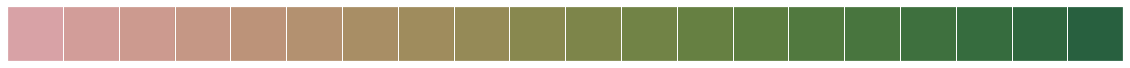

In [342]:
cmap = sns.cubehelix_palette(20, start=15, rot=-1.00, dark = .3, light=.7)
sns.palplot(cmap)

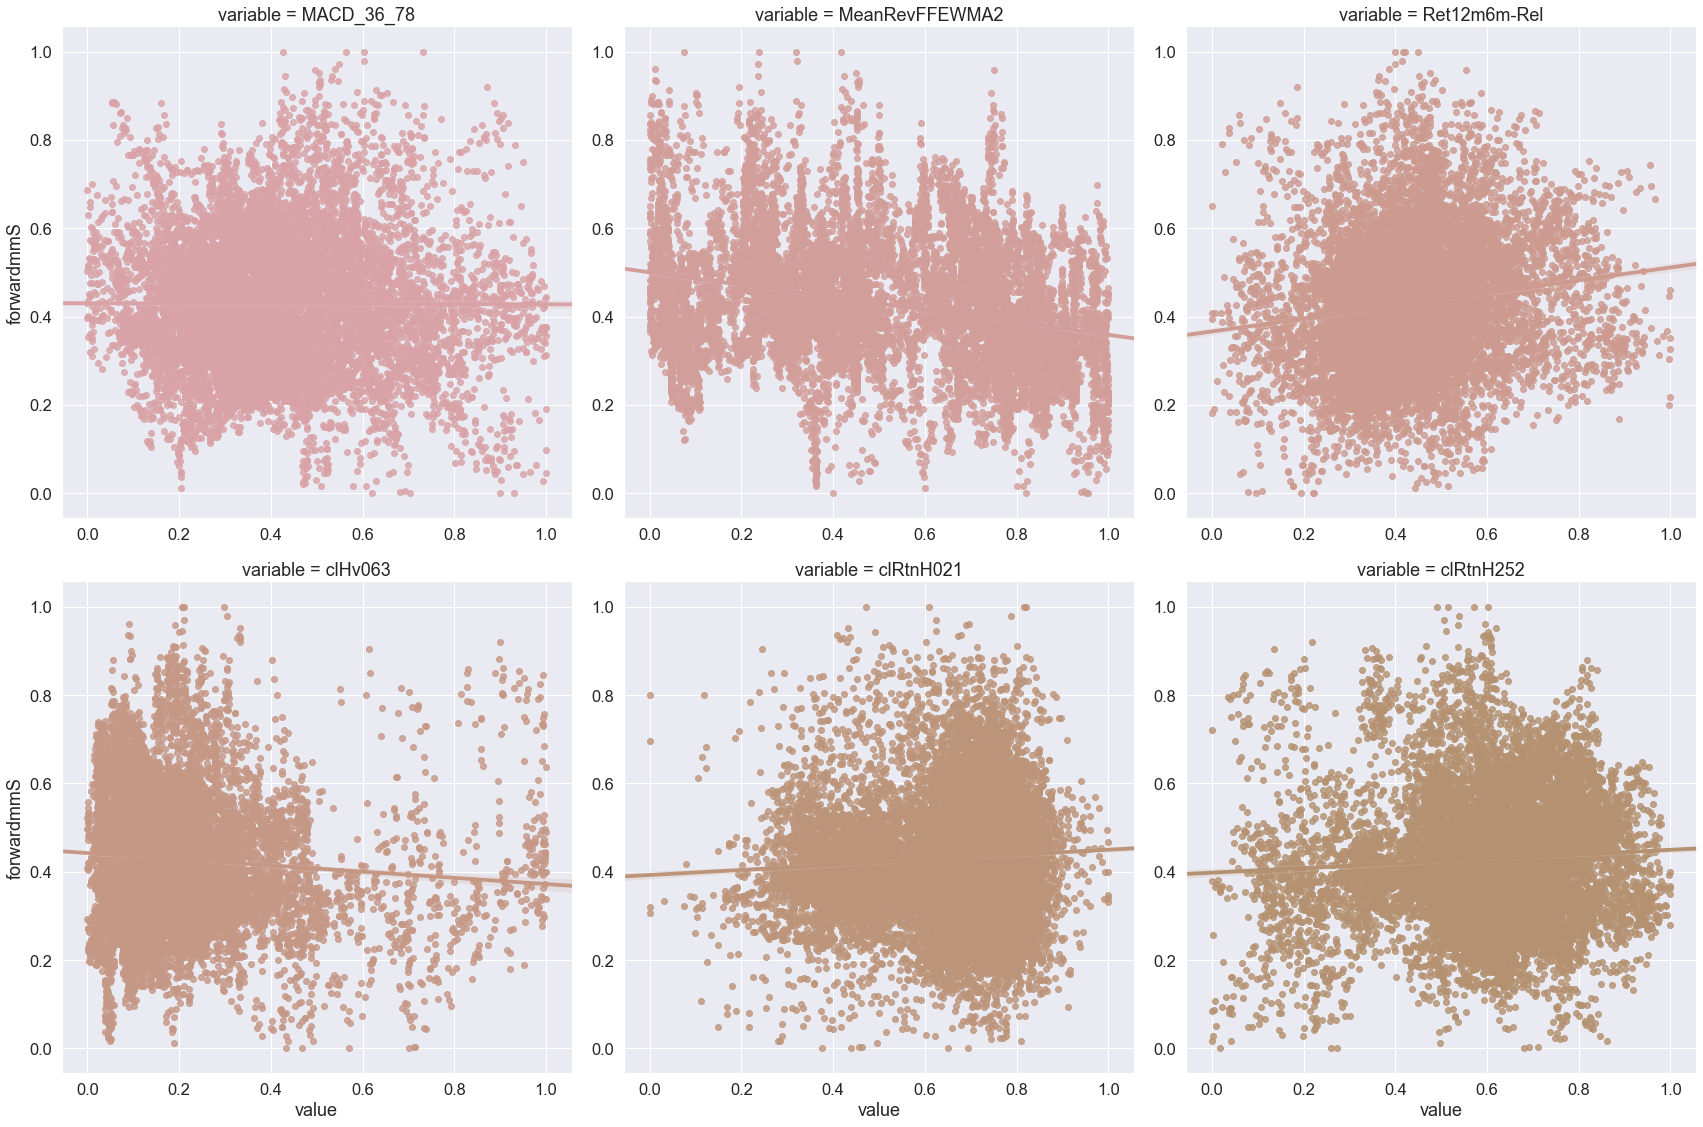

In [344]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(40,40)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ids = list(mdatar.columns[mdatar.columns.isin(rFeatures) == False])

mmdatar = pd.melt(mdatar[(ids + selFeatsSign)], 
                      id_vars=ids, 
                      value_vars=selFeatsSign)

g = sns.FacetGrid(mmdatar, col="variable", hue="variable",
                  palette=cmap,
                  height = 8, 
                  col_wrap = 3,
                  sharex=False, 
                  sharey=False,
                  margin_titles=True)
g.map(sns.regplot,'value','forwardmmS')
g.savefig('plots/FINALRelativeReturnsScatterPlots-3M-Defensive.png')

In [345]:
path = 'data/'
trial_stats.to_csv(path+'full_test_rDefensive_Final.csv')
#wf_pred.to_csv(path+'Walk_Forward_RELATIVE_Final.csv')

In [346]:
!jupyter nbconvert --to html ModelFit_s2.ipynb

[NbConvertApp] Converting notebook ModelFit_s2.ipynb to html
[NbConvertApp] Writing 3784308 bytes to ModelFit_s2.html
